MNIST手写数字识别 - 简化ResNet模型 (StepLR学习率衰减)
设备: cpu
批次大小: 64, 训练轮数: 8
初始学习率: 0.01
学习率衰减: StepLR (step_size=2, gamma=0.5)
--------------------------------------------------
加载MNIST数据集...
训练集: 60000 张图片
测试集: 10000 张图片

初始化模型...
模型总参数量: 28,554

优化器配置:
  优化器: Adam (初始lr=0.01)
  学习率调度器: StepLR (step_size=2, gamma=0.5)
  预期学习率变化: 每2个epoch衰减0.5倍

开始训练...
--------------------------------------------------
Epoch 1: 损失 = 0.2192, 准确率 = 93.86%, 学习率 = 0.010000, 耗时 = 55.69秒
Epoch 2: 损失 = 0.0660, 准确率 = 97.95%, 学习率 = 0.005000, 耗时 = 52.50秒
Epoch 3: 损失 = 0.0365, 准确率 = 98.83%, 学习率 = 0.005000, 耗时 = 45.01秒
Epoch 4: 损失 = 0.0340, 准确率 = 98.92%, 学习率 = 0.002500, 耗时 = 50.31秒
Epoch 5: 损失 = 0.0230, 准确率 = 99.29%, 学习率 = 0.002500, 耗时 = 51.23秒
Epoch 6: 损失 = 0.0205, 准确率 = 99.36%, 学习率 = 0.001250, 耗时 = 54.38秒
Epoch 7: 损失 = 0.0146, 准确率 = 99.56%, 学习率 = 0.001250, 耗时 = 47.68秒
Epoch 8: 损失 = 0.0135, 准确率 = 99.59%, 学习率 = 0.000625, 耗时 = 47.72秒

训练完成！总训练时间: 404.52秒 (6.74分钟)

--------------------------------------------------
开始测试...
测试

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

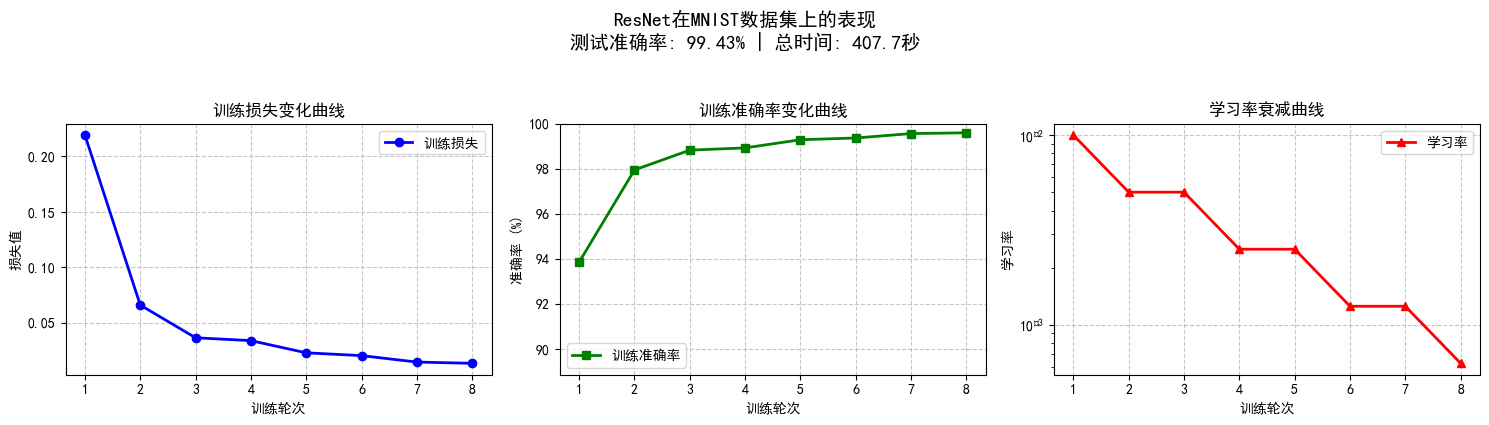


训练过程统计

总体准确率: 9943/10000 = 99.43%
测试准确率: 99.43%
训练轮次: 8
最终训练损失: 0.0135
初始学习率: 0.010000
最终学习率: 0.000625
测试时间: 3.04秒

模型已保存为 'simple_resnet_mnist_stepLR.pth'
可视化图表已保存为 'training_results_line_charts.png'
总程序运行时间: 407.71秒 (6.80分钟)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import traceback
import sys
import time  # 新增导入时间模块

# ==================== 1. 超参数与设备配置 ====================
def setup_environment():
    """设置环境和超参数"""
    BATCH_SIZE = 64
    EPOCHS = 8
    INITIAL_LR = 0.01  # 初始学习率0.01
    STEP_SIZE = 2      # 学习率衰减步长
    GAMMA = 0.5        # 学习率衰减系数
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"设备: {DEVICE}")
    print(f"批次大小: {BATCH_SIZE}, 训练轮数: {EPOCHS}")
    print(f"初始学习率: {INITIAL_LR}")
    print(f"学习率衰减: StepLR (step_size={STEP_SIZE}, gamma={GAMMA})")
    print("-" * 50)
    
    return BATCH_SIZE, EPOCHS, INITIAL_LR, STEP_SIZE, GAMMA, DEVICE

# ==================== 2. 数据加载 ====================
def load_mnist_data(batch_size):
    """加载MNIST数据集"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    print("加载MNIST数据集...")
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"训练集: {len(train_dataset)} 张图片")
    print(f"测试集: {len(test_dataset)} 张图片")
    
    return train_loader, test_loader

# ==================== 3. 简化模型定义 ====================
class SimpleResBlock(nn.Module):
    """简化的残差块"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        
    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

class SimpleResNet(nn.Module):
    """简化的ResNet模型"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.resblock1 = SimpleResBlock(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.resblock2 = SimpleResBlock(32)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 10)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# ==================== 4. 训练和测试函数 ====================
def train_one_epoch(model, train_loader, criterion, optimizer, scheduler, device, epoch, epoch_start_time):
    """训练一个epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    # 每2个epoch后更新学习率
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    epoch_time = time.time() - epoch_start_time
    
    print(f"Epoch {epoch+1}: 损失 = {avg_loss:.4f}, 准确率 = {accuracy:.2f}%, "
          f"学习率 = {current_lr:.6f}, 耗时 = {epoch_time:.2f}秒")
    return avg_loss, accuracy, current_lr

def test_model(model, test_loader, criterion, device):
    """测试模型性能"""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    test_start_time = time.time()
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_time = time.time() - test_start_time
    test_accuracy = 100. * correct / total
    avg_loss = test_loss / len(test_loader)
    
    print(f"测试结果: 损失 = {avg_loss:.4f}, 准确率 = {test_accuracy:.2f}%, 耗时 = {test_time:.2f}秒")
    return avg_loss, test_accuracy, all_preds, all_targets, test_time

# ==================== 5. 可视化函数（仅保留折线图） ====================
def visualize_with_matplotlib(train_losses, train_accs, learning_rates, test_accuracy, all_preds, all_targets, total_time, test_time):
    """使用纯matplotlib创建可视化图表 - 仅折线图"""
    # -------------------------- 设置中文字体 start ------------------------
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 修复负号显示为方块的问题
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建1行3列的子图布局
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    epochs = range(1, len(train_losses) + 1)
    
    # 1. 训练损失曲线
    ax1 = axes[0]
    ax1.plot(epochs, train_losses, 'b-o', linewidth=2, markersize=6, label='训练损失')
    ax1.set_title('训练损失变化曲线', fontsize=12, fontweight='bold')
    ax1.set_xlabel('训练轮次', fontsize=10)
    ax1.set_ylabel('损失值', fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    
    # 2. 训练准确率曲线
    ax2 = axes[1]
    ax2.plot(epochs, train_accs, 'g-s', linewidth=2, markersize=6, label='训练准确率')
    ax2.set_title('训练准确率变化曲线', fontsize=12, fontweight='bold')
    ax2.set_xlabel('训练轮次', fontsize=10)
    ax2.set_ylabel('准确率 (%)', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    # 设置合适的Y轴范围
    y_min = max(0, min(train_accs) - 5)
    ax2.set_ylim([y_min, 100])
    
    # 添加最终准确率标注
    final_acc = train_accs[-1]
    
    # 3. 学习率变化曲线
    ax3 = axes[2]
    ax3.plot(epochs, learning_rates, 'r-^', linewidth=2, markersize=6, label='学习率')
    ax3.set_title('学习率衰减曲线', fontsize=12, fontweight='bold')
    ax3.set_xlabel('训练轮次', fontsize=10)
    ax3.set_ylabel('学习率', fontsize=10)
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.set_yscale('log')  # 对数坐标，更清晰显示衰减
    ax3.legend()
    
    # 添加学习率衰减标注
    initial_lr = learning_rates[0]
    final_lr = learning_rates[-1]
    
    # 设置整体标题（增加时间信息）
    plt.suptitle(f'ResNet在MNIST数据集上的表现\n测试准确率: {test_accuracy:.2f}% | 总时间: {total_time:.1f}秒', 
                 fontsize=14, fontweight='bold', y=1.05)
    
    # 调整布局
    plt.tight_layout()
    plt.savefig('training_results_line_charts.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 打印详细统计信息
    print("\n" + "="*60)
    print("训练过程统计")
    print("="*60)
    
    # 计算每个类别的准确率
    class_correct = [0] * 10
    class_total = [0] * 10
    
    for i in range(len(all_targets)):
        label = all_targets[i]
        class_total[label] += 1
        if all_preds[i] == label:
            class_correct[label] += 1
    
    # 计算总体统计
    total_correct = sum(class_correct)
    total_samples = sum(class_total)
    overall_accuracy = 100 * total_correct / total_samples
    
    print(f"\n总体准确率: {total_correct}/{total_samples} = {overall_accuracy:.2f}%")
    print(f"测试准确率: {test_accuracy:.2f}%")
    print(f"训练轮次: {len(train_losses)}")
    print(f"最终训练损失: {train_losses[-1]:.4f}")
    print(f"初始学习率: {learning_rates[0]:.6f}")
    print(f"最终学习率: {learning_rates[-1]:.6f}")
    print(f"测试时间: {test_time:.2f}秒")
    print("="*60)

# ==================== 6. 主函数 ====================
def main():
    """主训练流程"""
    try:
        # 记录总开始时间
        program_start_time = time.time()
        
        # 1. 设置环境
        BATCH_SIZE, EPOCHS, INITIAL_LR, STEP_SIZE, GAMMA, DEVICE = setup_environment()
        
        # 2. 加载数据
        train_loader, test_loader = load_mnist_data(BATCH_SIZE)
        
        # 3. 初始化模型
        print("\n初始化模型...")
        model = SimpleResNet().to(DEVICE)
        
        total_params = sum(p.numel() for p in model.parameters())
        print(f"模型总参数量: {total_params:,}")
        
        # 4. 定义损失函数和优化器
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=INITIAL_LR)
        
        # 5. 添加StepLR学习率调度器
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, 
            step_size=STEP_SIZE, 
            gamma=GAMMA
        )
        
        print(f"\n优化器配置:")
        print(f"  优化器: Adam (初始lr={INITIAL_LR})")
        print(f"  学习率调度器: StepLR (step_size={STEP_SIZE}, gamma={GAMMA})")
        print(f"  预期学习率变化: 每{STEP_SIZE}个epoch衰减{GAMMA}倍")
        
        # 6. 训练循环
        print("\n开始训练...")
        print("-" * 50)
        
        train_losses = []
        train_accuracies = []
        learning_rates_history = []
        
        # 记录训练开始时间
        training_start_time = time.time()
        
        for epoch in range(EPOCHS):
            epoch_start_time = time.time()
            loss, acc, current_lr = train_one_epoch(model, train_loader, criterion, 
                                                   optimizer, scheduler, DEVICE, epoch, epoch_start_time)
            train_losses.append(loss)
            train_accuracies.append(acc)
            learning_rates_history.append(current_lr)
        
        # 计算总训练时间
        total_training_time = time.time() - training_start_time
        print(f"\n训练完成！总训练时间: {total_training_time:.2f}秒 ({total_training_time/60:.2f}分钟)")
        
        # 7. 测试模型
        print("\n" + "-" * 50)
        print("开始测试...")
        test_loss, test_accuracy, all_preds, all_targets, test_time = test_model(
            model, test_loader, criterion, DEVICE
        )
        
        # 计算总程序运行时间
        total_program_time = time.time() - program_start_time
        
        # 8. 可视化结果（传递时间参数）
        visualize_with_matplotlib(train_losses, train_accuracies, learning_rates_history, 
                                 test_accuracy, all_preds, all_targets, total_program_time, test_time)
        
        # 9. 保存模型
        torch.save(model.state_dict(), 'simple_resnet_mnist_stepLR.pth')
        print(f"\n模型已保存为 'simple_resnet_mnist_stepLR.pth'")
        print("可视化图表已保存为 'training_results_line_charts.png'")
        print(f"总程序运行时间: {total_program_time:.2f}秒 ({total_program_time/60:.2f}分钟)")
        
    except Exception as e:
        print(f"\n错误: {str(e)}")
        traceback.print_exc()
        return 1
    
    return 0

# ==================== 7. 程序入口 ====================
if __name__ == "__main__":
    print("="*60)
    print("MNIST手写数字识别 - 简化ResNet模型 (StepLR学习率衰减)")
    print("="*60)
    
    # 调用主函数
    main()